# Introduction to connecting and Querying the Augur DB

## Connect to your database

Until the Operate First enviroment can connect to the DB, use config file to access. Do not push config file to Github repo

In [1]:
import psycopg2
import pandas as pd 
import sqlalchemy as salc
import json
import os
import networkx as nx

with open("../comm_cage.json") as config_file:
    config = json.load(config_file)

In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

### Retrieve Available Respositories

In [3]:
aval_repos = pd.DataFrame()
repo_query = salc.sql.text(f"""
             SET SCHEMA 'augur_data';
             SELECT a.rg_name,
                a.repo_group_id,
                b.repo_name,
                b.repo_id,
                b.forked_from,
                b.repo_archived,
                b.repo_git
            FROM
                repo_groups a,
                repo b
            WHERE
                a.repo_group_id = b.repo_group_id
            ORDER BY
                rg_name,
                repo_name;
    """)
aval_repos = pd.read_sql(repo_query, con=engine)
display(aval_repos)
aval_repos.dtypes

,rg_name,repo_group_id,repo_name,repo_id,forked_from,repo_archived,repo_git
0,3scale,25556,3scale,33134,Parent not available,0.0,https://github.com/3scale/3scale.github.io
1,3scale,25556,3scale-amp-openshift-templates,33126,Parent not available,0.0,https://github.com/3scale/3scale-amp-openshift...
2,3scale,25556,3scale-api-python,33130,3scale-qe/3scale-api-python,0.0,https://github.com/3scale/3scale-api-python
3,3scale,25556,3scale-api-ruby,33158,Parent not available,0.0,https://github.com/3scale/3scale-api-ruby
4,3scale,25556,3scale-go-client,33169,Parent not available,0.0,https://github.com/3scale/3scale-go-client
...,...,...,...,...,...,...,...
10956,zerodayz,25482,sosreport-operator,30872,andreaskaris/sosreport-operator,0.0,https://github.com/zerodayz/sosreport-operator
10957,zerodayz,25482,talos,30863,siderolabs/talos,0.0,https://github.com/zerodayz/talos
10958,zerodayz,25482,tests,30838,kata-containers/tests,0.0,https://github.com/zerodayz/tests
10959,zerodayz,25482,web,30839,openshifttips/web,0.0,https://github.com/zerodayz/web


rg_name           object
repo_group_id      int64
repo_name         object
repo_id            int64
forked_from       object
repo_archived    float64
repo_git          object
dtype: object

In [4]:
issue_contrib = pd.DataFrame()
repo_query = salc.sql.text(f"""
            SET SCHEMA 'augur_data';
            SELECT r.repo_id,
            r.repo_git,
            i.cntrb_id
            FROM
            repo r, issues i
             WHERE
            i.repo_id = r.repo_id
            limit 500000
    """)
issue_contrib = pd.read_sql(repo_query, con=engine)
issue_contrib.columns =['Repo ID', 'Git', 'Issue Authors']

display(issue_contrib)
issue_contrib.dtypes

,Repo ID,Git,Issue Authors
0,24441,https://github.com/operate-first/operate-first...,25438.0
1,24441,https://github.com/operate-first/operate-first...,25438.0
2,24441,https://github.com/operate-first/operate-first...,25438.0
3,24441,https://github.com/operate-first/operate-first...,25438.0
4,24441,https://github.com/operate-first/operate-first...,25449.0
...,...,...,...
499995,27812,https://github.com/kubernetes/test-infra,NaN
499996,27812,https://github.com/kubernetes/test-infra,NaN
499997,27812,https://github.com/kubernetes/test-infra,NaN
499998,27812,https://github.com/kubernetes/test-infra,NaN


Repo ID            int64
Git               object
Issue Authors    float64
dtype: object

In [5]:
issue_contrib.nunique()

Repo ID          1188
Git              1188
Issue Authors    5456
dtype: int64

In [6]:
pr_contrib = pd.DataFrame()
repo_query = salc.sql.text(f"""
            SET SCHEMA 'augur_data';
            SELECT r.repo_id,
            r.repo_git,
            prm.cntrb_id
            FROM
            repo r, pull_request_meta prm 
             WHERE
            prm.repo_id = r.repo_id
            limit 500000
    """)
pr_contrib = pd.read_sql(repo_query, con=engine)
pr_contrib.columns =['Repo ID', 'Git', 'PR Creators']

display(pr_contrib)
pr_contrib.dtypes

,Repo ID,Git,PR Creators
0,27458,https://github.com/operate-first/continuous-de...,25443
1,27458,https://github.com/operate-first/continuous-de...,25465
2,27458,https://github.com/operate-first/continuous-de...,25444
3,27458,https://github.com/operate-first/continuous-de...,25465
4,27458,https://github.com/operate-first/continuous-de...,25433
...,...,...,...
499995,34959,https://github.com/avocado-framework/avocado-vt,33044
499996,34959,https://github.com/avocado-framework/avocado-vt,2215471
499997,28857,https://github.com/apache/pulsar-helm-chart,2232632
499998,28857,https://github.com/apache/pulsar-helm-chart,2204176


Repo ID         int64
Git            object
PR Creators     int64
dtype: object

In [7]:
pr_contrib.nunique()

Repo ID         3033
Git             3033
PR Creators    20365
dtype: int64

In [8]:
prr_contrib = pd.DataFrame()
repo_query = salc.sql.text(f"""
            SET SCHEMA 'augur_data';
            SELECT r.repo_id,
            r.repo_git,
            prr.cntrb_id
            FROM
            repo r, pull_request_reviews prr
             WHERE
            prr.repo_id = r.repo_id
            limit 500000
    """)
prr_contrib = pd.read_sql(repo_query, con=engine)
prr_contrib.columns =['Repo ID', 'Git', 'PR Reviewers']

display(prr_contrib)
prr_contrib.dtypes

,Repo ID,Git,PR Reviewers
0,27458,https://github.com/operate-first/continuous-de...,25443
1,27458,https://github.com/operate-first/continuous-de...,25443
2,27458,https://github.com/operate-first/continuous-de...,25444
3,27458,https://github.com/operate-first/continuous-de...,25444
4,27458,https://github.com/operate-first/continuous-de...,25446
...,...,...,...
26800,28308,https://github.com/ansible/lightbulb,58328
26801,28308,https://github.com/ansible/lightbulb,58179
26802,28308,https://github.com/ansible/lightbulb,58059
26803,28308,https://github.com/ansible/lightbulb,58232


Repo ID          int64
Git             object
PR Reviewers     int64
dtype: object

In [9]:
prr_contrib.nunique()

Repo ID         191
Git             191
PR Reviewers    961
dtype: int64

In [10]:
commit_contrib = pd.DataFrame()
repo_query = salc.sql.text(f"""
            SET SCHEMA 'augur_data';
            SELECT r.repo_id,
            r.repo_git,
            ca.cntrb_id
            FROM
            repo r, commits c, contributors_aliases ca
             WHERE
            c.repo_id = r.repo_id and
            c.cmt_committer_email = ca.alias_email
            limit 500000
    """)
commit_contrib = pd.read_sql(repo_query, con=engine)
commit_contrib.columns =['Repo ID', 'Git', 'Commit Creators']

display(commit_contrib)
commit_contrib.dtypes

,Repo ID,Git,Commit Creators
0,27857,https://github.com/kubernetes/autoscaler,2268734
1,27857,https://github.com/kubernetes/autoscaler,2268734
2,27857,https://github.com/kubernetes/autoscaler,2268734
3,27857,https://github.com/kubernetes/autoscaler,2268734
4,27857,https://github.com/kubernetes/autoscaler,2268734
...,...,...,...
499995,30352,https://github.com/apache/spark-website,2208553
499996,30352,https://github.com/apache/spark-website,2208553
499997,30352,https://github.com/apache/spark-website,2208553
499998,30352,https://github.com/apache/spark-website,2208553


Repo ID             int64
Git                object
Commit Creators     int64
dtype: object

In [11]:
commit_contrib.nunique()


Repo ID            316
Git                316
Commit Creators    115
dtype: int64

In [12]:
df_all_new = pd.DataFrame()


In [13]:
df_all_new = pd.merge(commit_contrib, issue_contrib, on=['Repo ID','Git'], how='inner')

In [14]:
df_all_new.nunique()

Repo ID              34
Git                  34
Commit Creators      82
Issue Authors      1031
dtype: int64

In [15]:
df_all_new = pd.merge(df_all_new, pr_contrib, on=['Repo ID', 'Git'], how='inner')

In [16]:
df_all_new.nunique()

Repo ID             12
Git                 12
Commit Creators     11
Issue Authors       87
PR Creators        174
dtype: int64

In [17]:
df_all_new = pd.merge(df_all_new, prr_contrib, on=['Repo ID', 'Git'], how='outer')


In [18]:
df_all_new.nunique()


Repo ID            203
Git                203
Commit Creators     11
Issue Authors       87
PR Creators        174
PR Reviewers       961
dtype: int64

In [19]:
df_all_new.head()


,Repo ID,Git,Commit Creators,Issue Authors,PR Creators,PR Reviewers
0,26919,https://github.com/redhat-developer/app-servic...,2204072.0,NaN,1707253.0,NaN
1,26919,https://github.com/redhat-developer/app-servic...,2204072.0,NaN,1707253.0,NaN
2,26919,https://github.com/redhat-developer/app-servic...,2204072.0,NaN,1707253.0,NaN
3,26919,https://github.com/redhat-developer/app-servic...,2204072.0,NaN,1707253.0,NaN
4,26919,https://github.com/redhat-developer/app-servic...,2204072.0,NaN,1707253.0,NaN


In [20]:
df_all_new.drop_duplicates(inplace=True)

In [ ]:
df_all.nunique()

In [21]:
# Group by repo and count the number of issue authors, PR creators, PR reviewers and commit creators
df = df_all.groupby('Repo ID')['Commit Creators','Issue Authors','PR Creators','PR Reviewers'].count()

<ipython-input-21-7c282220a37e>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = df_all.groupby('Repo ID')['Commit Creators','Issue Authors','PR Creators','PR Reviewers'].count()


In [22]:
df = df.reset_index()

In [23]:
df.head()

,Repo ID,Commit Creators,Issue Authors,PR Creators,PR Reviewers
0,24441,0,0,0,10
1,24442,0,0,0,12
2,25445,0,0,0,5
3,25450,0,0,0,8
4,26894,128,112,128,0


In [24]:
df.nunique()

Repo ID            203
Commit Creators     10
Issue Authors        9
PR Creators         10
PR Reviewers        27
dtype: int64

### Contributor Graph

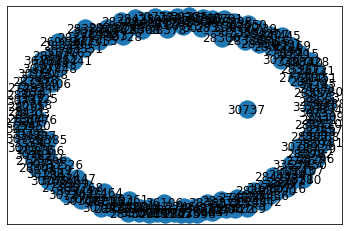

In [25]:
G = nx.from_pandas_edgelist(df,
                            source='Repo ID',
                            target='Repo ID',
                            edge_attr=['Issue Authors', 'PR Creators', 'Commit Creators', 'PR Reviewers'],
                            create_using=nx.MultiGraph())
                            
nx.draw_networkx(G)

In [26]:
print(nx.info(G))

Name: 
Type: MultiGraph
Number of nodes: 203
Number of edges: 203
Average degree:   2.0000
